<a href="https://colab.research.google.com/github/AnisVahedi/WM-and-Ripples-in-PFC/blob/master/Merging_datasets_and_claculate_rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import zipfile
from google.colab import files
import pandas as pd
import numpy as np
from scipy.io import loadmat

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# for merging loading


In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat


# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.io import loadmat
# import mne

# Recursive function to extract the first non-list element
def nlist_extract(nlist):
    """Recursively extracts the first non-list element."""
    if isinstance(nlist, (np.ndarray, list)) and len(nlist) > 0:
        return nlist_extract(nlist[0])
    else:
        return nlist

# Function to apply 'nlist_extract' to specific columns of the DataFrame
def apply_nlist_extract_to_selected(df, columns_to_flatten):
    """Applies nlist_extract to specific columns of the DataFrame."""
    for col in columns_to_flatten:
        if col in df.columns:
            df[col] = df[col].apply(nlist_extract)
    return df

# Function to convert MATLAB struct to pandas DataFrame
def struct_to_df(struct):
    """Converts MATLAB struct array to pandas DataFrame."""
    data_dict = {name: struct[name].squeeze() for name in struct.dtype.names}
    # Handle scalars or arrays correctly
    for key, val in data_dict.items():
        if val.ndim == 0:
            data_dict[key] = [val.item()]
    return pd.DataFrame(data_dict)

# Load the MAT files
lfp_data = loadmat('/content/drive/MyDrive/Spike Anilysis/LFP_A2_ADR_po_1.mat')
fire_data = loadmat('/content/drive/MyDrive/Spike Anilysis/sFire_A2_ADR_po_1.mat')
ripple_data = loadmat('/content/drive/MyDrive/Spike Anilysis/Ripple_A2_ADR_po_1.mat')
# Extract the structs
lfp_struct = lfp_data['structArray']
fire_struct = fire_data['structArray']
ripple_struct = ripple_data['structArray']
# Convert both LFP and Fire structs to DataFrames
lfp_df = struct_to_df(lfp_struct)
fire_df = struct_to_df(fire_struct)
ripple_df = struct_to_df(ripple_struct)
# Columns to selectively flatten
columns_to_flatten_lfp = ['Filename', 'Trial', 'Class', 'lfp_channel']
columns_to_flatten_fire = ['Filename', 'trial', 'class', 'channel']
columns_to_flatten_ripple = ['Filename', 'Trial', 'Class', 'lfp_channel']
# Apply selective flattening
lfp_df = apply_nlist_extract_to_selected(lfp_df, columns_to_flatten_lfp)
fire_df = apply_nlist_extract_to_selected(fire_df, columns_to_flatten_fire)
ripple_df = apply_nlist_extract_to_selected(ripple_df, columns_to_flatten_ripple)
# Ensure data types for merging are consistent
lfp_df['Trial'] = pd.to_numeric(lfp_df['Trial'], errors='coerce')
fire_df['trial'] = pd.to_numeric(fire_df['trial'], errors='coerce')
ripple_df['Trial'] = pd.to_numeric(ripple_df['Trial'], errors='coerce')

lfp_df['Class'] = pd.to_numeric(lfp_df['Class'], errors='coerce')
fire_df['class'] = pd.to_numeric(fire_df['class'], errors='coerce')
ripple_df['Class'] = pd.to_numeric(ripple_df['Class'], errors='coerce')

lfp_df['lfp_channel'] = pd.to_numeric(lfp_df['lfp_channel'], errors='coerce')
fire_df['channel'] = pd.to_numeric(fire_df['channel'], errors='coerce')
ripple_df['lfp_channel'] = pd.to_numeric(ripple_df['lfp_channel'], errors='coerce')
# Merge both datasets based on specified columns
# First, merge LFP and firing data
merged_df_temp = pd.merge(
    lfp_df, fire_df,
    left_on=['Filename', 'Trial', 'Class', 'lfp_channel'],
    right_on=['Filename', 'trial', 'class', 'channel'],
    suffixes=('_LFP', '_Fire')
)

# Then, merge the result with the ripple data
merged_df = pd.merge(
    merged_df_temp, ripple_df,
    on=['Filename', 'Trial', 'Class', 'lfp_channel'],  # common keys for LFP and ripple
    how='inner',  # or 'outer' if you want to keep all rows from both sides
    suffixes=('', '_RIPPLE')
)


# Convert merged LFP and Fire signals into MNE RawArray
sfreq = 500  # Sampling frequency in Hz

# # Save the merged DataFrame as a CSV file
# output_file_path = 'merged_data.csv'





1.8957462491829407


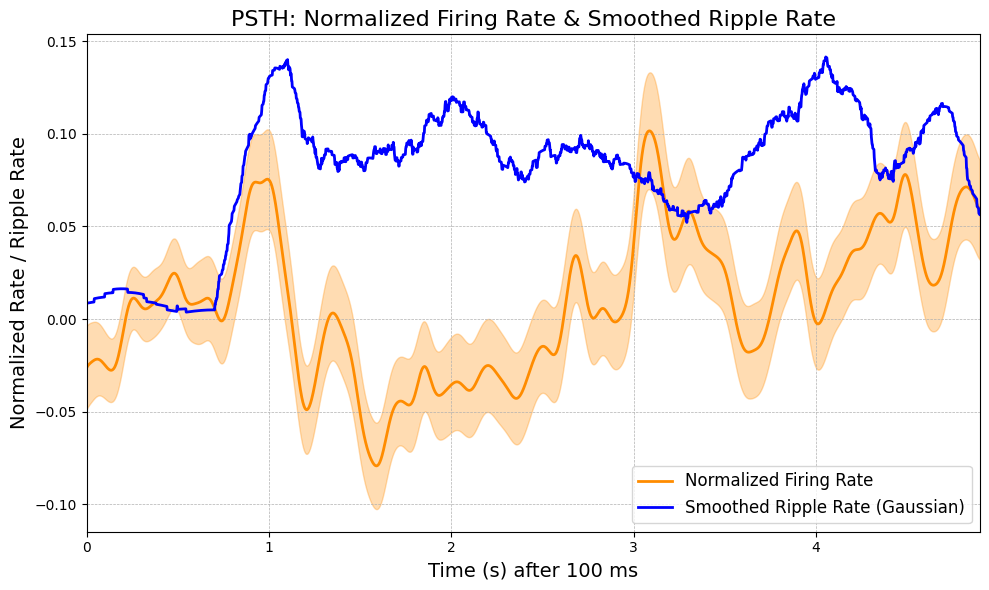

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import numpy as np
import matplotlib.pyplot as plt



def has_ripple(ripple):
    """
    Return True if there is at least one valid ripple event (i.e. a list/array with length >2)

    """
    if ripple is None:
        return False
    if isinstance(ripple, (list, np.ndarray)) and len(ripple) == 0:
        return False
    try:
        # If there are multiple events, each event must be a list/array with length > 1
        if isinstance(ripple[0], (list, np.ndarray)):
            return any((len(event) > 0) for event in ripple)
        else:
            # Single event stored as a flat array; require at least 3 elements.
            return (len(ripple) > 0)
    except Exception:
        return False

def valid_ripple_counts(ripple):
    """
    Return True only if:
      - The number of valid ripple events in the first 500 samples is less than or equal
        to the number of valid ripple events between samples 500 and 2500, AND
      - The number of valid ripple events between samples 500 and 2500 is greater than 1.
    A valid ripple event is one that is a list/array with length > 1.
    """
    if ripple is None:
        return False
    if isinstance(ripple, (list, np.ndarray)) and len(ripple) == 0:
        return False
    try:
        # If there are multiple events, only consider those with length > 1.
        if isinstance(ripple[0], (list, np.ndarray)):
            event_starts = [event[0] for event in ripple if len(event) > 1]
        else:
            # Single event: check if it has at least 1 elements.
            event_starts = [ripple[0]] if len(ripple) > 1 else []
    except Exception:
        event_starts = []
    event_starts = np.array(event_starts)
    count_first = np.sum(event_starts < 500)
    count_second = np.sum((event_starts >500) & (event_starts < 2500))
    return (count_first < count_second) and (count_second > 0)

# merged_df_filtered = merged_df[merged_df['ripple_events'].apply(has_ripple_after_500)]
# First filter: Keep only rows with a ripple event after sample 500.
merged_df_filtered = merged_df[merged_df['ripple_events'].apply(has_ripple)]
# Second filter: Remove rows where the count in the first 500 samples is greater than the count from 500 to 2500.

merged_df_filtered = merged_df_filtered[merged_df_filtered['ripple_events'].apply(valid_ripple_counts)]


# Parameters for analysis
sfreq = 500          # Sampling frequency in Hz
duration = 5         # Duration in seconds to consider (up to 5 s)
start_cut = int(0.1 * sfreq)   # Remove first 100 ms (50 samples)
end_cut = int(duration * sfreq)  # Up to 5 s (2500 samples)
num_samples_window = end_cut - start_cut  # Number of samples in our window

# -----------------------------------------------------
# 1. Firing Rate PSTH
# -----------------------------------------------------
# Slice firing rate signals (for filtered trials) after the 100 ms cut.
fire_signals_cut = np.stack([
    np.array(signal).flatten()[start_cut:end_cut]
    for signal in merged_df_filtered['fire']
])
psth_firing = np.mean(fire_signals_cut, axis=0)
time_axis = np.arange(psth_firing.shape[0]) / sfreq  # time axis in seconds

# ---------------------
# 2. Ripple Rate PSTH via Gaussian Convolution
# ---------------------
# Create a binary ripple event train for each trial.
# Each trial gets a zero vector of length num_samples_window.
# For each ripple event (using the start time), we mark the corresponding sample as 1.
binary_ripple_trials = []
for ripple in merged_df_filtered['ripple_events']:
    binary_vector = np.zeros(num_samples_window)
    if ripple is None or (isinstance(ripple, (list, np.ndarray)) and len(ripple) == 0):
        binary_ripple_trials.append(binary_vector)
    else:
        try:
            # If multiple events are present, each event is a list/array (e.g., [start, peak, end])
            events = ripple if isinstance(ripple, list) else ripple.tolist()
            if isinstance(events[0], (list, np.ndarray)):
                event_starts = np.array([event[0] for event in events])
            else:
                event_starts = np.array([events[0]])
        except Exception:
            event_starts = np.array([ripple[0]])
        # Shift event times relative to our window start (sample 50)
        event_times = event_starts - start_cut
        # Only count events that fall within our window
        event_times = event_times[(event_times >= 0) & (event_times < num_samples_window)]
        for ev in event_times:
            idx = int(round(ev))
            if 0 <= idx < num_samples_window:
                binary_vector[idx] = 1
    binary_ripple_trials.append(binary_vector)
binary_ripple_trials = np.array(binary_ripple_trials)

# Define a Gaussian kernel with a specified sigma (in samples).
# The kernel is not normalized by area so that its maximum (at t=0) remains 1.
sigma = 100  # adjust sigma as needed (in samples)
kernel_width = int(1* sigma)  # consider ±3 sigma
x_kernel = np.arange(-kernel_width, kernel_width )

gaussian_kernel = np.exp(-0.5 * (x_kernel / sigma)**2)

# Convolve each trial's binary ripple vector with the Gaussian kernel.
smoothed_ripple_trials = []
for trial in binary_ripple_trials:
    conv_result = np.convolve(trial, gaussian_kernel, mode='same')
    # Optional: If you wish to cap overlapping events, you can clip the result to a maximum of 1.
    # conv_result[conv_result > 1] = 1
    smoothed_ripple_trials.append(conv_result)
smoothed_ripple_trials = np.array(smoothed_ripple_trials)

# Compute the average smoothed ripple rate across trials.
psth_ripple_smoothed = np.mean(smoothed_ripple_trials, axis=0)

# --- Normalize Firing Rate Using the Reference Period (samples 20 to 490) ---
# 'fire_signals_cut' is a 2D array with shape (n_trials, num_samples_window)
fire_signals_cut = np.stack([
    np.array(signal).flatten()[start_cut:end_cut]
    for signal in merged_df_filtered['fire']
])
psth_firing = np.mean(fire_signals_cut, axis=0)
time_axis = np.arange(psth_firing.shape[0]) / sfreq
fire_signals_cut
ref_period = fire_signals_cut[:, 0:300]  # Reference period (adjust indices as needed)

trial_means = np.mean(ref_period, axis=1)  # Mean for each trial over the reference period
# Compute a single normalization factor: the mean of the standard deviations (across trials) in the reference period
norm_factor = np.mean(np.sqrt(np.var(ref_period, axis=0)))
# Normalize each trial's firing rate by subtracting the absolute value of its reference mean and dividing by norm_factor
norm_fire_signals = (fire_signals_cut - np.abs(trial_means)[:, None]) / norm_factor
print(norm_factor )
# Compute the mean and standard error (SEM) across trials for the normalized firing rate
mean_firing = np.mean(norm_fire_signals, axis=0)
SEM_firing = np.std(norm_fire_signals, axis=0) / np.sqrt(norm_fire_signals.shape[0])

# --- Plotting Both Normalized Firing Rate and Smoothed Ripple Rate ---
plt.figure(figsize=(10, 6))
# Plot the normalized firing rate with SEM shadow
plt.plot(time_axis, mean_firing, color='darkorange', linewidth=2, label='Normalized Firing Rate')
plt.fill_between(time_axis, mean_firing - SEM_firing, mean_firing + SEM_firing, color='darkorange', alpha=0.3)
# Plot the smoothed ripple rate
plt.plot(time_axis, psth_ripple_smoothed, color='blue', linewidth=2, label='Smoothed Ripple Rate (Gaussian)')

plt.xlabel('Time (s) after 100 ms', fontsize=14)
plt.ylabel('Normalized Rate / Ripple Rate', fontsize=14)
plt.title('PSTH: Normalized Firing Rate & Smoothed Ripple Rate', fontsize=16)
plt.xlim(0, num_samples_window / sfreq)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()




In [4]:
from scipy.io import savemat

# Create a dictionary representing a MATLAB struct.
merged_struct = {'merged': {col: merged_df[col].values for col in merged_df.columns}}

# Save the struct to a .mat file.
savemat('/content/drive/MyDrive/Spike Anilysis/merged_data_ADR_A2_1.mat', merged_struct)


# Load  merged data

In [ ]:
dataset_adr_a2_1 = loadmat('/content/drive/MyDrive/Spike Anilysis/merged_data_ADR_A2_1.mat')

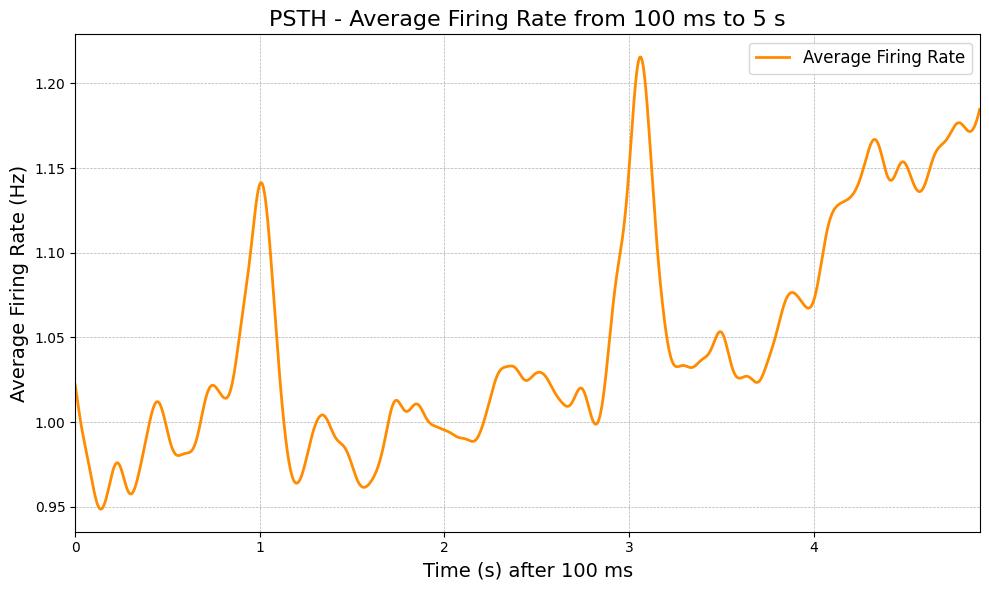

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sfreq = 500  # Sampling frequency in Hz
duration = 5  # Total duration to consider (in seconds)

# Calculate indices: remove the first 100ms and then keep data until 5 seconds.
start_cut = int(0.1 * sfreq)  # 100ms corresponds to 50 samples
end_cut = int(duration * sfreq)  # Up to 5 seconds (2500 samples)

# Slice each firing rate signal accordingly before stacking
fire_signals_cut = np.stack([
    np.array(signal).flatten()[start_cut:end_cut]
    for signal in merged_df['fire']
])

# Calculate the PSTH (average firing rate) across trials
psth = np.mean(fire_signals_cut, axis=0)

# Create a relative time axis (starting at 0 after the 100ms cut)
time_axis = np.arange(psth.shape[0]) / sfreq  # in seconds

# Plot the PSTH with enhanced aesthetics
plt.figure(figsize=(10, 6))
plt.plot(time_axis, psth, color='darkorange', linewidth=2, label='Average Firing Rate')
plt.xlabel('Time (s) after 100 ms', fontsize=14)
plt.ylabel('Average Firing Rate (Hz)', fontsize=14)
plt.title('PSTH - Average Firing Rate from 100 ms to 5 s', fontsize=16)
plt.xlim(0, (end_cut - start_cut) / sfreq)  # x-axis from 0 to 4.9 seconds
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
